In [0]:
# !pip uninstall tensorflow-gpu
# !pip install tensorflow-gpu==2.0.0-beta1

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
import json
import glob
import skimage

print(tf.__version__)

2.0.0-beta1


In [0]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/BookAI/training-set-1'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_img(path):
  loaded_img = keras.preprocessing.image.load_img(path)
  img_array = keras.preprocessing.image.img_to_array(loaded_img)
  grayscale = skimage.color.rgb2gray(img_array)
  result = np.reshape(grayscale, (*np.shape(grayscale), 1))
  
  return result

def load_rect(path):
  with open(path) as json_file:  
    data = json.load(json_file)
    obj = data['objects'][0]
    title = obj['description']
    p1 = obj['points']['exterior'][0]
    p2 = obj['points']['exterior'][1]
    p1_x = p1[0]
    p1_y = p1[1]
    p2_x = p2[0]
    p2_y = p2[1]
    
    p1 = [min(p1_x, p2_x), min(p1_y, p2_y)]
    p2 = [max(p1_x, p2_x), max(p1_y, p2_y)]
  return [*p1, *p2]

def resize_image(original_image, original_rect, new_size=100):
  resized_image = skimage.transform.resize(original_image, (new_size, new_size))
  p1_x = round(original_rect[0] / original_image.shape[1] * new_size)
  p1_y = round(original_rect[1] / original_image.shape[0] * new_size)
  p2_x = round(original_rect[2] / original_image.shape[1] * new_size)
  p2_y = round(original_rect[3] / original_image.shape[0] * new_size)
  return (resized_image, [p1_x, p1_y, p2_x, p2_y])

In [0]:
jpg_paths = glob.glob(root_path + '/img/*.jpg')

print(len(jpg_paths), 'jpgs found')

jpg_paths = jpg_paths[:]

def load_img_rect_tuple(img_path):
  img = load_img(img_path)
  json_path = img_path.replace('/img/', '/ann/').replace('.jpg', '.jpg.json')
  rect = load_rect(json_path)
  return (img, rect)

Covers = list(map(lambda p: load_img_rect_tuple(p), jpg_paths))

print(len(Covers), 'covers loaded')

Covers = list(map(lambda cover: resize_image(cover[0], cover[1]), Covers))

print(len(Covers), 'covers resized')

print('Covers shape:', np.shape(Covers))
print('Image shape:', np.shape(Covers[0][0]))
print('Rect shape:', np.shape(Covers[0][1]))

240 jpgs found
240 covers loaded
240 covers resized
Covers shape: (240, 2)
Image shape: (100, 100, 1)
Rect shape: (4,)


Original size: (793, 540, 1)
New size: (100, 100, 1)
Original rect: [427, 75, 501, 414]
New rect: [79, 9, 93, 52]


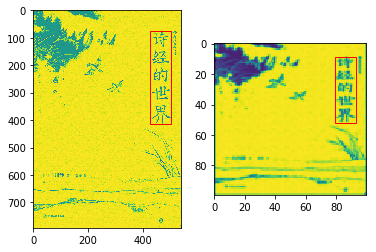

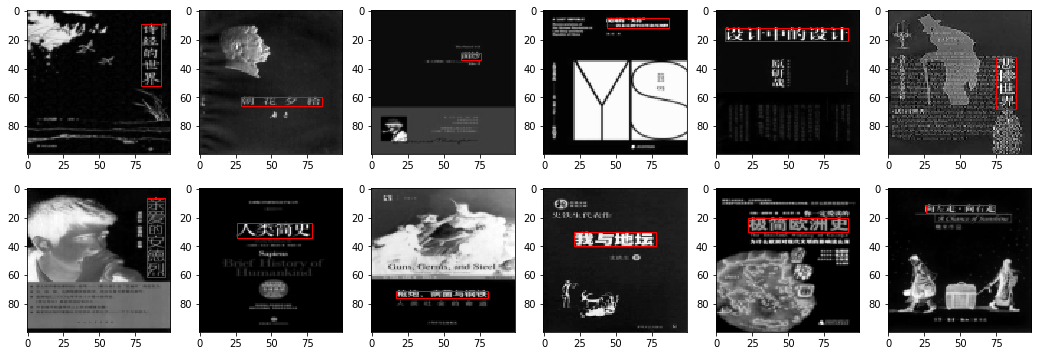

In [0]:
def debug_resize_image():
  original_image, original_rect = load_img_rect_tuple(jpg_paths[0])
  new_size = 100
  resized_image, new_rect = resize_image(original_image, original_rect, new_size)

  print('Original size:', original_image.shape)
  print('New size:', resized_image.shape)

  print('Original rect:', original_rect)
  print('New rect:', new_rect)

  fig, axes = plt.subplots(1,2)
  axes[0].imshow(original_image[:,:,0])
  axes[0].add_patch(matplotlib.patches.Rectangle((original_rect[0], original_rect[1]), original_rect[2]-original_rect[0], original_rect[3]-original_rect[1], color="red", fill=False))
  axes[1].imshow(resized_image[:,:,0])
  axes[1].add_patch(matplotlib.patches.Rectangle((new_rect[0], new_rect[1]), new_rect[2]-new_rect[0], new_rect[3]-new_rect[1], color="red", fill=False))
  plt.show()

def debug_loaded_resized_image():
  fig = plt.figure(figsize=(18, 6))
  columns = 6
  rows = 2
  for i in range(min(len(Covers), columns * rows)):
    img, rect = Covers[i]

    sp = fig.add_subplot(rows, columns, i + 1)
    corner = (rect[0], rect[1])
    width = rect[2] - rect[0]
    height = rect[3] - rect[1]
    sp.add_patch(matplotlib.patches.Rectangle(corner, width, height, color="red", fill=False))
    plt.imshow(img[:,:,0] / 255, cmap=plt.cm.binary)

  plt.show()


debug_resize_image()
debug_loaded_resized_image()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
train_x = np.array([c[0] for c in Covers]) / 255
train_y = np.array([c[1] for c in Covers]) / 100
print(np.min(train_x), np.max(train_x), np.mean(train_x))
print(np.min(train_y), np.max(train_y), np.mean(train_y))
print(np.shape(train_x))
print(np.shape(train_y))

0.0 1.0 0.6229026115980697
0.0 1.0 0.45285416666666667
(240, 100, 100, 1)
(240, 4)


In [0]:
# Normal initializer
initializer = keras.initializers.RandomNormal(mean=0, stddev=0.05, seed=13)

model = keras.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=2, activation='relu', padding='same', input_shape=(100,100,1), kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.5),
    
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=2, activation='relu', padding='same', kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.5),
    
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu', kernel_initializer=initializer),
    keras.layers.Dense(512, activation='relu', kernel_initializer=initializer),
    keras.layers.Dense(128, activation='relu', kernel_initializer=initializer),
    keras.layers.Dense(64, activation='relu', kernel_initializer=initializer),
    keras.layers.Dense(32, activation='relu', kernel_initializer=initializer),
    keras.layers.Dense(16, activation='relu', kernel_initializer=initializer),
    keras.layers.Dense(4, activation='linear', kernel_initializer=initializer), # relu could be dead, do not use relu
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 256)     1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 256)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 50, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 128)       131200    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 25, 128)      

In [0]:
from tensorflow.keras import backend as K # https://github.com/keras-team/keras/issues/12379

# L1 distance loss is K.mean(K.abs(pred - truth))

# shape of truth/pred: (num_sample, *[shape of output]), i.e. (num_sample, 4)
# coordinate range [0, 1]
def rect_loss(truth, pred):    
  tx1 = truth[:, 0]
  ty1 = truth[:, 1]
  tx2 = truth[:, 2]
  ty2 = truth[:, 3]
  px1 = pred[:, 0]
  py1 = pred[:, 1]
  px2 = pred[:, 2]
  py2 = pred[:, 3]

  l_one_diff = K.abs(tx1 - px1) + K.abs(ty1 - py1) + K.abs(tx2 - px2) + K.abs(ty2 - py2)
  
  t_centerx = (tx1 + tx2) / 2
  t_centery = (ty1 + ty2) / 2
  p_centerx = (px1 + px2) / 2
  p_centery = (py1 + py2) / 2

  t_width = tx2 - tx1
  t_height = ty2 - ty1
  p_width = px2 - px1 # might be negative
  p_height = py2 - py1
  
  center_dist_square = K.square(t_centerx - p_centerx) + K.square(t_centery - p_centery) / 2 # make it within range [0,1]
  width_diff = K.abs(t_width - p_width)
  height_diff = K.abs(t_height - p_height)
  
  def f(x): # x[0, 1]
    eps = 0.00001
    return (1 / (2 - x + eps) - 0.5) * 3 # 3 is a magic number
  
  error_center = f(center_dist_square)
  error_width = f(width_diff) # do not divide t_width
  error_height = f(height_diff)
  error_l_one = l_one_diff / 4
  
  return error_center + 0.3 * error_width + 0.3 * error_height + error_l_one

model.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [0]:
model_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=True, mode='auto', baseline=None, restore_best_weights=False),
    keras.callbacks.TerminateOnNaN(),
]

history = model.fit(train_x[:220], train_y[:220], epochs=500, batch_size=150, validation_split=0.1, callbacks=model_callbacks, shuffle=True, verbose=True)

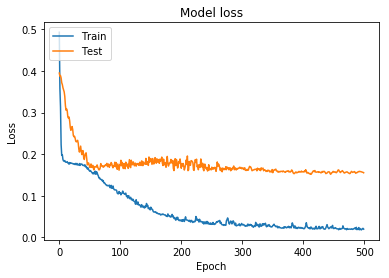

In [0]:
# for key in history.history:
#     print(key)

# # Plot training & validation accuracy values
# plt.plot(history.history['mae'])
# plt.plot(history.history['val_mae'])
# plt.title('Model MAE')
# plt.ylabel('MAE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

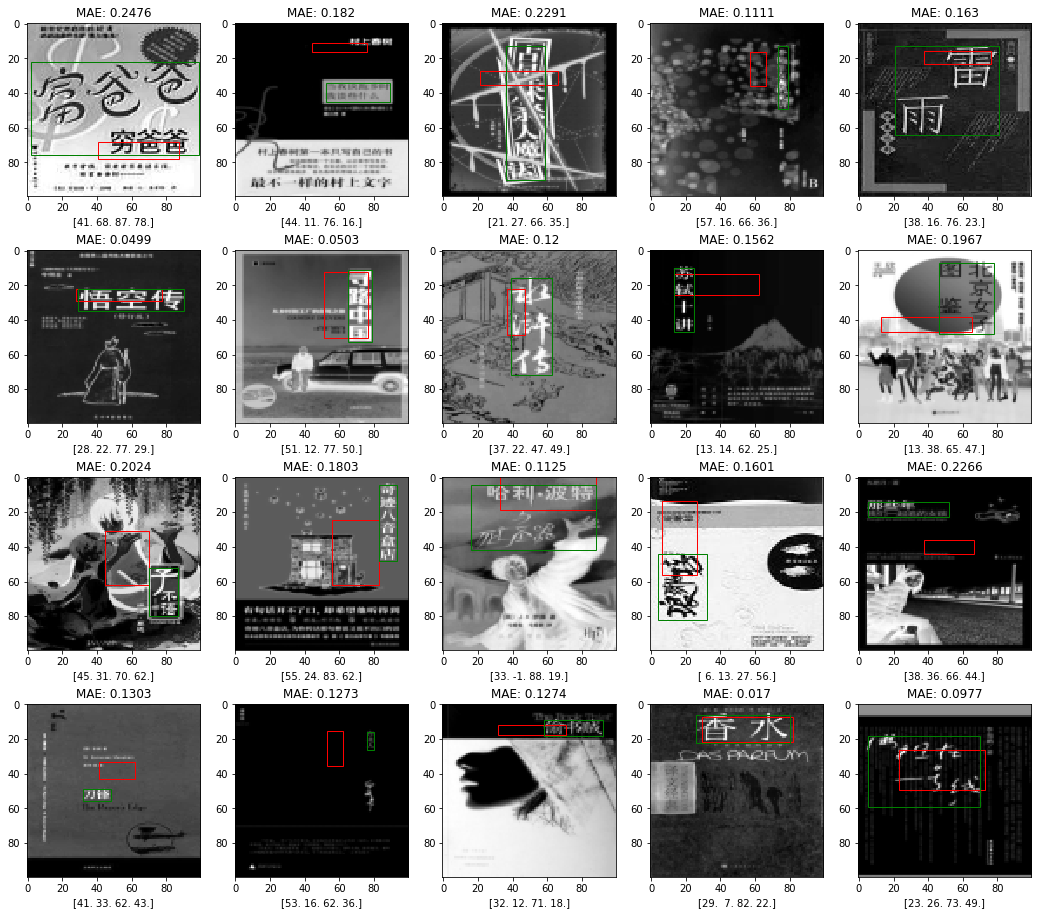

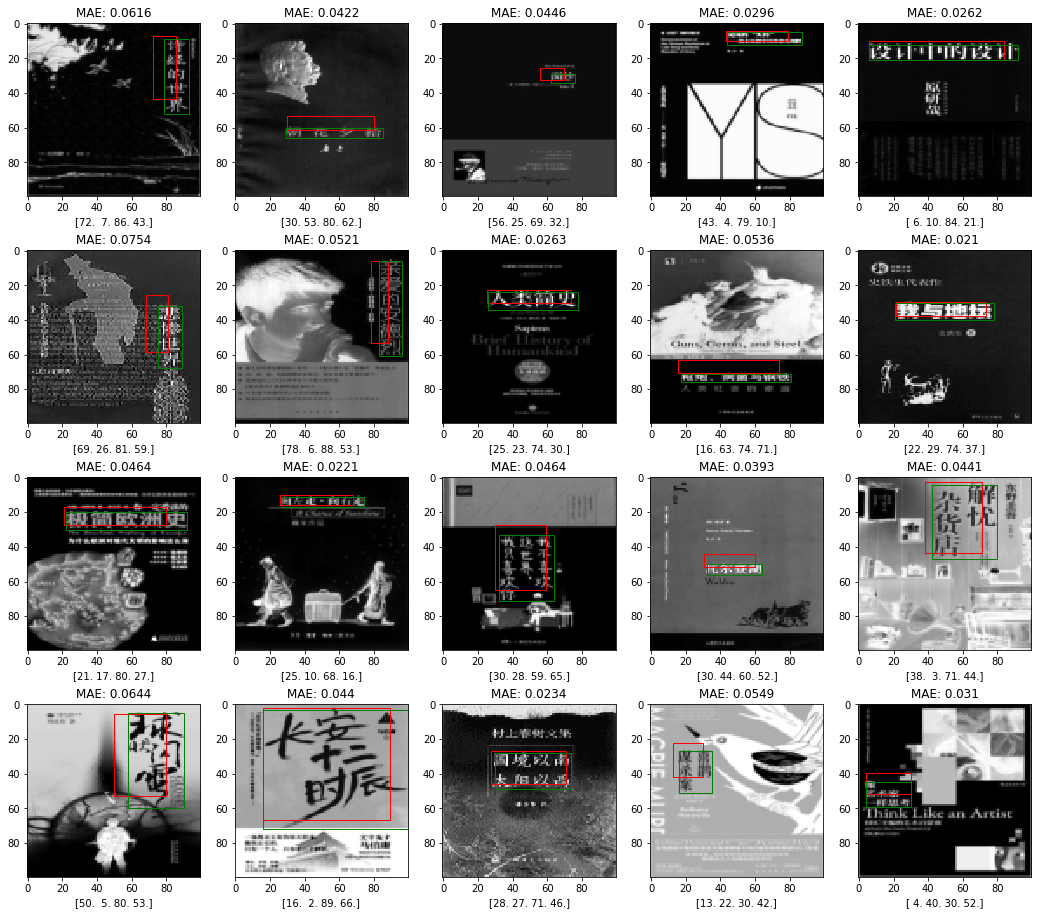

In [0]:
def mae_loss(truth, pred):
  return np.mean(np.absolute(pred - truth))

test_x = train_x[220:]
test_y = train_y[220:]

validate_x = train_x[:20]
validate_y = train_y[:20]

test_p = model.predict_on_batch(test_x)
validate_p = model.predict_on_batch(validate_x)

def draw_predictions(predicts, truths, images):
  fig = plt.figure(figsize=(18, 16))
  columns = 5
  rows = 4
  for i in range(min(len(predicts), columns * rows)):
    img = images[i] * 255
    rect = predicts[i] * 100
    rect_truth = truths[i] * 100

    error = mae_loss(rect_truth / 100, rect / 100)

    ax = fig.add_subplot(rows, columns, i + 1)
    corner = (rect[0], rect[1])
    width = rect[2] - rect[0]
    height = rect[3] - rect[1]
    corner2 = (rect_truth[0], rect_truth[1])
    width2 = rect_truth[2] - rect_truth[0]
    height2 = rect_truth[3] - rect_truth[1]
    ax.add_patch(matplotlib.patches.Rectangle(corner, width, height, color="red", fill=False))
    ax.add_patch(matplotlib.patches.Rectangle(corner2, width2, height2, color="green", fill=False))
    ax.set_title("MAE: " + str(round(error, 4)))
    ax.set_xlabel(str(np.round(rect)))
    plt.imshow(img[:,:,0] / 255, cmap=plt.cm.binary)

  plt.show()


draw_predictions(test_p, test_y, test_x)
print("")
print("")
draw_predictions(validate_p, validate_y, validate_x)
